<a href="https://colab.research.google.com/github/fvillena/biocompu/blob/master/5.2-image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning: Segmentación de imágenes

Deep learning es un tipo de aprendizaje de máquinas en donde las predicciones se realizan a través de una serie de operaciones matriciales concatenadas. Uno de los elementos más importantes en el Deep Learning es la casi nula ingeniería de características. En el ejemplo que veremos ahora, se utiliza un conjunto de imágenes segmentadas para realizar el entrenamiento de un modelo de segmentación automática de núcleos celulares, este entrenamiento simplemente se realiza con los pixeles crudos de las imágenes, sin ingeniería de características.

Para este notebook se están utilizando los datos y códigos de la competencia 2018 Data Science Bowl https://www.kaggle.com/c/data-science-bowl-2018

**Importante**: Este notebook fue programado para sólo funcionar en Google Colab https://colab.research.google.com/

In [ ]:
# Importamos todos los paquetes y módulos para entrenar el modelo

import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

Google Colab nos ofrece poder utilizar GPUs (Graphical Processing Units) para realizar el entrenamiento. La utilización de este hardware nos facilita un entrenamiento muy significativamente más rápido que el entrenamiento en CPU.

In [ ]:
tf.test.gpu_device_name() # Verificamos que Tensorflow está utilizando una GPU

'/device:GPU:0'

In [ ]:
# Obtenemos el conjunto de datos de entrenamiento y prueba desde el servidor de SASIBA.
!wget --no-check-certificate "http://www.sasiba.uchile.cl/index.php/s/JGh8wjMx6ZfY5pV/download" -O stage1_train.zip
!wget --no-check-certificate "http://www.sasiba.uchile.cl/index.php/s/pc9rJ4bJsCY2ZIG/download" -O stage1_test.zip

--2021-05-10 02:34:28--  http://www.sasiba.uchile.cl/index.php/s/JGh8wjMx6ZfY5pV/download
Resolving www.sasiba.uchile.cl (www.sasiba.uchile.cl)... 200.89.79.35
Connecting to www.sasiba.uchile.cl (www.sasiba.uchile.cl)|200.89.79.35|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.sasiba.uchile.cl/index.php/s/JGh8wjMx6ZfY5pV/download [following]
--2021-05-10 02:34:28--  https://www.sasiba.uchile.cl/index.php/s/JGh8wjMx6ZfY5pV/download
Connecting to www.sasiba.uchile.cl (www.sasiba.uchile.cl)|200.89.79.35|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 82923446 (79M) [application/zip]
Saving to: ‘stage1_train.zip’

stage1_train.zip    100%[===================>]  79.08M  21.6MB/s    in 4.4s    

2021-05-10 02:34:33 (18.0 MB/s) - ‘stage1_train.zip’ saved [82923446/82923446]

--2021-05-10 02:34:34--  http://www.sasiba.uchile.cl/index.php/s/pc9rJ4bJsCY2ZIG/download
Resolving w

In [ ]:
# Descomprimimos los conjuntos de datos.
!unzip -q stage1_train.zip -d stage1_train/
!unzip -q stage1_test.zip -d stage1_test/

In [ ]:
IMG_WIDTH = 128 # Ancho en el que se redimensionarán las imágenes.
IMG_HEIGHT = 128 # Alto en el que se redimensionarán las imágenes.
IMG_CHANNELS = 3 # Canales de color que tienen las imágenes (rojo, verde y azul)
TRAIN_PATH = 'stage1_train/' # Ubicación del conjunto de datos de entrenamiento.
TEST_PATH = 'stage1_test/' # Ubicación del conjunto de datos de prueba.

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# Establecemos una semilla para la generación de datos aleatorios
seed = 11 
random.seed = seed
np.random.seed = seed

In [ ]:
# Obtenemos los nombres de las imágenes de entrenamiento y prueba
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [ ]:
# Redimensionamos todas las imágenes
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [06:03<00:00,  1.84it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:01<00:00, 36.36it/s]

Done!


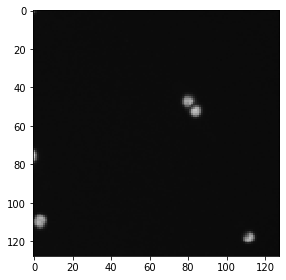

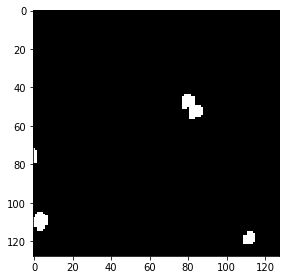

In [ ]:
# Verificamos la imagen cruda y la máscara de segmentación de una imagen al azar.
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

U-Net es una arquitectura especializada para la segmentación de imágenes biomédicas https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/ .

Esta arquitectura utiliza una serie de capas de convolución para realizar las predicciones y el esquema es el siguiente:

![U-Net Architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [ ]:
# Esta es la implementación en TensorFlow de U-Net

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s) # Capa convolucional
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(2)])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

La arquitectura cuenta con alrededor de 2 millones de parámetros que serán entrenados.

In [ ]:
# Entrenamiento del modelo

earlystopper = EarlyStopping(patience=5, verbose=1)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper])

Epoch 1/50
38/38 [==============================] - 38s 99ms/step - loss: 0.5126 - mean_io_u: 0.4001 - val_loss: 0.2294 - val_mean_io_u: 0.4120
Epoch 2/50
38/38 [==============================] - 2s 46ms/step - loss: 0.2137 - mean_io_u: 0.3993 - val_loss: 0.1733 - val_mean_io_u: 0.4120
Epoch 3/50
38/38 [==============================] - 2s 46ms/step - loss: 0.1555 - mean_io_u: 0.3988 - val_loss: 0.1487 - val_mean_io_u: 0.4120
Epoch 4/50
38/38 [==============================] - 2s 47ms/step - loss: 0.1348 - mean_io_u: 0.4013 - val_loss: 0.1274 - val_mean_io_u: 0.4120
Epoch 5/50
38/38 [==============================] - 2s 47ms/step - loss: 0.1231 - mean_io_u: 0.4023 - val_loss: 0.1165 - val_mean_io_u: 0.4120
Epoch 6/50
38/38 [==============================] - 2s 47ms/step - loss: 0.1183 - mean_io_u: 0.4025 - val_loss: 0.1164 - val_mean_io_u: 0.4120
Epoch 7/50
38/38 [==============================] - 2s 47ms/step - loss: 0.1095 - mean_io_u: 0.3969 - val_loss: 0.1109 - val_mean_io_u: 0.412

In [ ]:
# Predicción sobre los datos de entrenamiento, validación y prueba

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

3/3 [==============================] - 0s 153ms/step


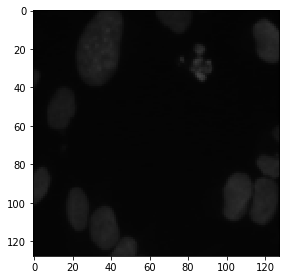

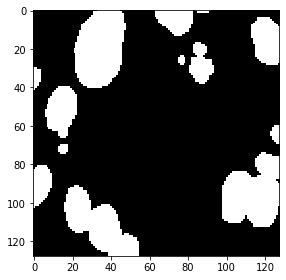

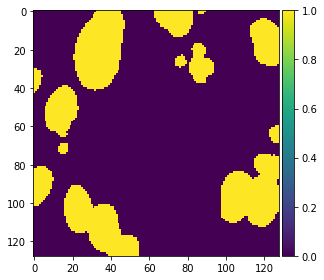

In [ ]:
# Visualizamos unas predicciones al azar sobre el conjunto de entrenamiento

ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

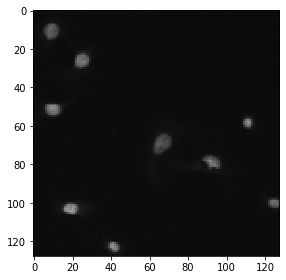

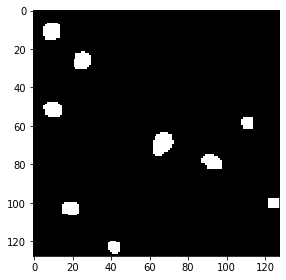

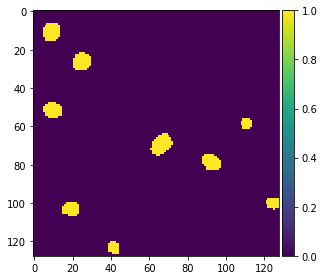

In [ ]:
# Visualizamos unas predicciones al azar sobre el conjunto de validación

ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

## Actividad

Visualiza la salida de alguna de las capas de convolución. Puedes utilizar las funciones de la clase anterior.

In [ ]:
# Prográmame!